In [1]:
import anndata 
import pandas as pd
import scanpy as sc
from amb import *
import matplotlib.pyplot as plt
import joblib
import pybedtools
import seaborn as sns
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi']=300
plt.rcParams['pdf.fonttype']=42

age_palette = get_age_palette()
age_palette['8wk'] = age_palette['2mo']

ct_palette = joblib.load('/home/qzeng_salk_edu/project/240319_te/AgingMajorType_Palette')
# replace the keys by .apply(lambda x: x.replace(' ','_').replace('/',''))
ct_palette = {x.replace(' ','_').replace('/',''):y for x,y in ct_palette.items()}

In [2]:
mc_type = 'CGN'
te_class = 'LINE'
inout='out20'

In [3]:
meta = pd.read_csv('/data/metadata/240104_m3C_META.csv', index_col =0)
meta['AgingMajorType'] = meta['AgingMajorType'].apply(lambda x: x.replace(' ','_').replace('/',''))
meta.head()

,InputReadPairs,InputReadPairsBP,TrimmedReadPairs,R1WithAdapters,R1QualTrimBP,R1TrimmedReadsBP,R2WithAdapters,R2QualTrimBP,R2TrimmedReadsBP,UniqueMappedReads,...,DissectionRegion,Region,Replicate,l1,mc_m3c-co_cluster_l1,mc_m3c-co_cluster_l2,CellType,CellSubclass,AgingMajorType,Class
cell,,,,,,,,,,,,,,,,,,,,,
AMB_220628_18mo_3F_4E_1_P1-1-I3-A1,1710943,516615812,1710512,309,766343,216480647,874,649089,230238965,1870858,...,ACB-1+ACB-2,Nucleus_accumbens,rep2,13,23,0-0,STR D1 Gaba,STR D1 Gaba,STR_D1_Gaba,Gaba
AMB_220628_18mo_3F_4E_1_P1-1-I3-A13,1688475,510130057,1688130,316,725418,213815592,832,673498,227339515,1820523,...,ACB-1+ACB-2,Nucleus_accumbens,rep2,11,6,12-6,STR-PAL Chst9 Gaba,STR D1 Sema5a Gaba,STR_D1_Sema5a_Gaba,Gaba
AMB_220628_18mo_3F_4E_1_P1-1-I3-A14,2158376,651979882,2157941,456,998559,273186730,1132,869248,290536436,2374173,...,ACB-1+ACB-2,Nucleus_accumbens,rep2,8,4,2-2,Astro NN,Astro-TE NN,Astro-TE_NN,NN
AMB_220628_18mo_3F_4E_1_P1-1-I3-A2,1582810,478040623,1582446,283,708122,200329678,853,626267,213020525,1746308,...,ACB-1+ACB-2,Nucleus_accumbens,rep2,9,8,7-6,STR D2 Gaba,STR D2 Gaba,STR_D2_Gaba,Gaba
AMB_220628_18mo_3F_4E_1_P1-1-I3-B1,1766714,533610284,1766279,411,810795,223604054,1045,691737,237777442,1968711,...,ACB-1+ACB-2,Nucleus_accumbens,rep2,13,23,0-0,STR D1 Gaba,STR D1 Gaba,STR_D1_Gaba,Gaba


In [4]:
genomepath = '/ref/m3C/mm10.main.nochrM.nochrY.chrom.sizes'
gene_bed = pybedtools.BedTool('TE_use.gencode.vM22.annotation.gene.sorted.bed')
te_bed = pybedtools.BedTool(f'/ref/repeatmasker-with-id/hg38.repeatmasker.repClass-{te_class}.bed')

In [5]:
ads = anndata.read_h5ad(f"adata/{te_class}.downsampled.h5ad")
ads

AnnData object with n_obs × n_vars = 7200 × 954358

In [6]:
if inout=='out20':
    feats = te_bed.subtract(gene_bed.flank(b=20000, g=genomepath)).to_dataframe()['name'].tolist()
elif inout=='out10':
    feats = te_bed.subtract(gene_bed.flank(b=10000, g=genomepath)).to_dataframe()['name'].tolist()
elif inout=='out2':
    feats = te_bed.subtract(gene_bed.flank(b=2000, g=genomepath)).to_dataframe()['name'].tolist()
elif inout=='out':
    feats = te_bed.subtract(gene_bed).to_dataframe()['name'].tolist()
elif inout=='in':
    feats = te_bed.intersect(gene_bed,).to_dataframe()['name'].tolist()
else:
    feats = te_bed.to_dataframe()['name'].tolist()

In [7]:
shared_feats = list(set(feats) & set(ads.var_names))
len(shared_feats)

546795

In [8]:
# select shared features from ads
ads = ads[:,shared_feats]
ads

View of AnnData object with n_obs × n_vars = 7200 × 546795

In [9]:
#ads = anndata.read_h5ad(f"adata/clustered.{te_class}.out20.tsne.h5ad")
ads.obs['Region'] = meta['Region']
ads.obs['celltype'] = meta['AgingMajorType']
ads.obs['Age'] = meta['Age']
# change ads.X to df
df = pd.DataFrame(ads.X.toarray(), index=ads.obs_names, columns=ads.var_names)
ads.obs['hypo_te_counts'] = df.sum(axis = 1)

# remove cells with cell types as DG-PIR_Ex_IMN
ads = ads[~ads.obs['celltype'].isin(['DG-PIR_Ex_IMN'])].copy()
ads

/var/tmp/ipykernel_64992/599647250.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ads.obs['Region'] = meta['Region']


AnnData object with n_obs × n_vars = 6900 × 546795
    obs: 'Region', 'celltype', 'Age', 'hypo_te_counts'

In [42]:
all_cts = ['Oligo_NN', 'STR_D1_Gaba', 'Astro-TE_NN', 'STR_D2_Gaba',
          'L6_CT_CTX_Glut', 'VLMC_NN', 'OPC_NN',
          'L23_IT_CTX_Glut', 'CA1-ProS_Glut', 'CEA-BST_Gaba', 'MEA-COA_Glut',
          'Pvalb_Gaba', 'L45_IT_CTX_Glut', 'L6bCT_ENT_Glut',
          'STR-PAL_Chst9_Gaba', 'L23_IT_PPP_Glut', 'Astro-NT_NN',
          'L6_IT_CTX_Glut', 'CA3_Glut', 'Sst_Gaba', 'MEA-BST_Gaba']

In [86]:
use_ct = ['DG_Glut','CA1-ProS_Glut','L6_CT_CTX_Glut','OPC_NN','Oligo_NN','MEA-BST_Gaba']

In [87]:
all_df = []

for ct in use_ct:
    tmp_ads = ads[ads.obs['celltype'] == ct].copy() 
    # tmp_ads.X to datafraem
    tmp_df = pd.DataFrame(tmp_ads.X.toarray(), index=tmp_ads.obs_names, columns=tmp_ads.var_names)
    tmp_df['Age'] = tmp_ads.obs['Age']
    tmp_df = tmp_df.groupby('Age').mean().T
    tmp_df = tmp_df[['8wk', '9mo','18mo']]
    # rename 8wk to 2mo
    
    # select top 10000 rows with highst std
    tmp_df = tmp_df.loc[tmp_df.std(axis=1).sort_values(ascending=False).index[:10000]]
    # zscore each row
    tmp_df = tmp_df.apply(lambda x: (x-x.mean())/x.std(), axis=1)
    tmp_df.columns = [f'{ct}.2mo',f'{ct}.9mo',f'{ct}.18mo']
    tmp_df.index = range(0, tmp_df.shape[0])
    all_df.append(tmp_df)
    print(ct)


DG_Glut
CA1-ProS_Glut
L6_CT_CTX_Glut
OPC_NN
Oligo_NN
MEA-BST_Gaba


In [88]:
all_df = pd.concat(all_df, axis=1)
all_df

,DG_Glut.2mo,DG_Glut.9mo,DG_Glut.18mo,CA1-ProS_Glut.2mo,CA1-ProS_Glut.9mo,CA1-ProS_Glut.18mo,L6_CT_CTX_Glut.2mo,L6_CT_CTX_Glut.9mo,L6_CT_CTX_Glut.18mo,OPC_NN.2mo,OPC_NN.9mo,OPC_NN.18mo,Oligo_NN.2mo,Oligo_NN.9mo,Oligo_NN.18mo,MEA-BST_Gaba.2mo,MEA-BST_Gaba.9mo,MEA-BST_Gaba.18mo
0,-0.776480,-0.351901,1.128381,-0.864681,1.095096,-0.230415,0.272607,0.835429,-1.108036,-0.459266,-0.687867,1.147133,-0.616366,-0.537435,1.153801,-0.623162,-0.530293,1.153455
1,-0.913006,-0.155718,1.068724,-1.113155,0.822405,0.290750,-0.318109,-0.802249,1.120358,-0.549395,-0.604862,1.154256,1.153056,-0.523175,-0.629881,-0.200185,1.084950,-0.884765
2,-0.983384,-0.032443,1.015827,-0.819806,-0.294326,1.114132,1.154129,-0.608523,-0.545606,0.057969,-1.027723,0.969755,1.154355,-0.552731,-0.601625,-0.595751,-0.558752,1.154503
3,0.101186,-1.046746,0.945560,-0.599411,-0.555005,1.154416,0.794344,0.328613,-1.122957,0.821602,0.291856,-1.113458,-1.081119,0.189297,0.891823,0.461355,0.686036,-1.147391
4,-0.178615,-0.898656,1.077271,-1.143769,0.709162,0.434606,0.043803,0.977379,-1.021182,0.085861,-1.040162,0.954301,0.993858,-1.006031,0.012172,-0.381972,-0.752716,1.134688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-1.154696,0.574489,0.580206,-1.152010,0.507775,0.644235,-0.376493,-0.757105,1.133598,-0.452152,1.146222,-0.694071,-0.888336,1.083030,-0.194694,-0.471739,-0.676872,1.148611
9996,0.726116,-1.140597,0.414481,-1.152010,0.507775,0.644235,-0.376493,-0.757105,1.133598,-0.452152,1.146222,-0.694071,-0.888336,1.083030,-0.194694,-0.471739,-0.676872,1.148611
9997,0.726116,-1.140597,0.414481,-1.152010,0.507775,0.644235,-0.376493,-0.757105,1.133598,-0.452152,1.146222,-0.694071,-1.154474,0.557417,0.597057,-0.471739,-0.676872,1.148611
9998,0.726116,-1.140597,0.414481,-1.152010,0.507775,0.644235,-0.376493,-0.757105,1.133598,1.135963,-0.388564,-0.747399,-1.154474,0.557417,0.597057,-0.471739,-0.676872,1.148611


In [89]:
# # distplot the std of rows
# plt.figure(figsize=(4,3))
# tmp_df.std(axis=1).plot(kind='kde')
# # select rows with std > 0.05
# tmp_df = tmp_df[tmp_df.std(axis=1)>0.03]


## pycomplex

In [90]:
import PyComplexHeatmap as pch
from PyComplexHeatmap import *
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi']=300
plt.rcParams['pdf.fonttype']=42

In [91]:
all_df = all_df.T
all_df

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
DG_Glut.2mo,-0.776480,-0.913006,-0.983384,0.101186,-0.178615,-0.497560,-0.467680,-0.257819,-0.762599,-0.197093,...,0.005876,1.005509,1.005509,1.005509,1.154696,-1.154696,0.726116,0.726116,0.726116,1.083415
DG_Glut.9mo,-0.351901,-0.155718,-0.032443,-1.046746,-0.898656,-0.653620,-0.680467,-0.845845,-0.369588,-0.886779,...,0.997049,-0.011111,-0.011111,-0.011111,-0.574489,0.574489,-1.140597,-1.140597,-1.140597,-0.887625
DG_Glut.18mo,1.128381,1.068724,1.015827,0.945560,1.077271,1.151180,1.148147,1.103664,1.132187,1.083872,...,-1.002925,-0.994398,-0.994398,-0.994398,-0.580206,0.580206,0.414481,0.414481,0.414481,-0.195789
CA1-ProS_Glut.2mo,-0.864681,-1.113155,-0.819806,-0.599411,-1.143769,-0.673497,0.657148,0.403180,-0.542874,-0.154623,...,-0.227795,-1.152010,-1.152010,-1.152010,-1.152010,-1.152010,-1.152010,-1.152010,-1.152010,-1.152010
CA1-ProS_Glut.9mo,1.095096,0.822405,-0.294326,-0.555005,0.709162,-0.475533,0.493689,0.735471,1.154027,-0.913682,...,-0.866451,0.507775,0.507775,0.507775,0.507775,0.507775,0.507775,0.507775,0.507775,0.507775
CA1-ProS_Glut.18mo,-0.230415,0.290750,1.114132,1.154416,0.434606,1.149030,-1.150838,-1.138652,-0.611153,1.068305,...,1.094245,0.644235,0.644235,0.644235,0.644235,0.644235,0.644235,0.644235,0.644235,0.644235
L6_CT_CTX_Glut.2mo,0.272607,-0.318109,1.154129,0.794344,0.043803,0.413921,-0.433606,1.122040,-0.274025,1.117467,...,-0.376493,-0.376493,-0.376493,-0.376493,-0.376493,-0.376493,-0.376493,-0.376493,-0.376493,-0.376493
L6_CT_CTX_Glut.9mo,0.835429,-0.802249,-0.608523,0.328613,0.977379,-1.140503,-0.710014,-0.324864,-0.834421,-0.810629,...,-0.757105,-0.757105,-0.757105,-0.757105,-0.757105,-0.757105,-0.757105,-0.757105,-0.757105,-0.757105
L6_CT_CTX_Glut.18mo,-1.108036,1.120358,-0.545606,-1.122957,-1.021182,0.726582,1.143620,-0.797176,1.108446,-0.306838,...,1.133598,1.133598,1.133598,1.133598,1.133598,1.133598,1.133598,1.133598,1.133598,1.133598
OPC_NN.2mo,-0.459266,-0.549395,0.057969,0.821602,0.085861,-0.655761,-0.134895,-0.248984,-0.306649,-1.021838,...,-0.452152,-0.452152,-0.452152,-0.452152,-0.452152,-0.452152,-0.452152,-0.452152,1.135963,1.135963


In [92]:
# row_annot 
row_annot = pd.DataFrame(index = all_df.index)
row_annot['celltype_annot'] = row_annot.index.map(lambda x: x.split('.')[0])
row_annot['age_annot'] = row_annot.index.map(lambda x: x.split('.')[1])
row_annot.head()

,celltype_annot,age_annot
DG_Glut.2mo,DG_Glut,2mo
DG_Glut.9mo,DG_Glut,9mo
DG_Glut.18mo,DG_Glut,18mo
CA1-ProS_Glut.2mo,CA1-ProS_Glut,2mo
CA1-ProS_Glut.9mo,CA1-ProS_Glut,9mo


In [93]:
left_ha = pch.HeatmapAnnotation(
                          label=pch.anno_label(row_annot.celltype_annot,merge=True,extend=False,
                                               adjust_color=True,luminance=0.75,relpos=(1,0.5), colors = 'black'), #,
                            CellType = pch.anno_simple(row_annot.celltype_annot,legend=True,colors=ct_palette),
                           Age=pch.anno_simple(row_annot.age_annot,legend=True,colors= age_palette),
                           verbose=1,axis=0,plot_legend=False)

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.5 mm


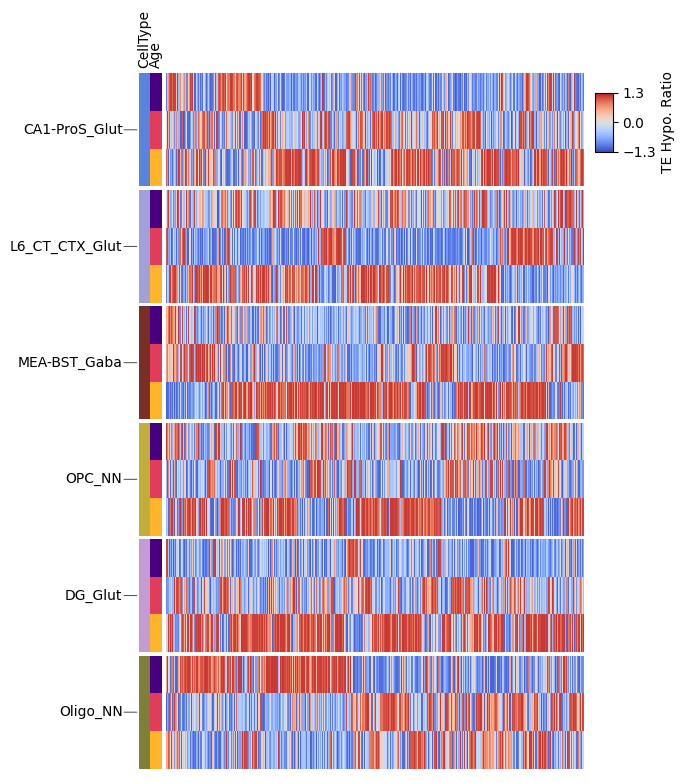

In [102]:
plt.figure(figsize=(6, 8))

cm = ClusterMapPlotter(
        data=all_df, 
        left_annotation=left_ha,
        vmin = -1.3, vmax = 1.3,
        col_cluster=True,row_cluster=False,
        label = 'TE Hypo. Ratio',
        
        cmap='coolwarm',rasterized=True,
        xticklabels_kws={'labelrotation':0,'labelcolor':'blue'},
        row_split = row_annot.celltype_annot, row_split_gap=0.8,
        )

plt.savefig(f"figure/by_locus_line.hypo_counts.heatmap.pdf", bbox_inches='tight')
plt.show()

In [83]:
# # use sns heatmap to plot the heatmap, order as the clustermap
# fig , ax = plt.subplots(figsize=(3,5), dpi = 100)

# sns.heatmap(all_df.iloc[g.dendrogram_row.reordered_ind], 
#             cmap='coolwarm', 
#             ax = ax,
#             rasterized=True,
#             vmin = -1.5,vmax = 1.5, 
#             cbar_kws={'label': 'Z-score'})

# # y label as LINE elements
# ax.set_ylabel(f'{tmp_df.shape[0]} LINE elements')
